# ST239 Assignment 1


##### Imports and dataset setup:

In [10]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
import numpy as np
import seaborn as sns
import scipy.stats as stats
from pathlib import Path
import statsmodels.api as sm

# Path setup
BASE_DIR = Path(r"C:/Users/prida/Desktop/ST239 Assignments/First_Assignment")  # paste dir to folder w/ datasets here
spam_phising_path = BASE_DIR / "spam_phishing.csv"
Q2_curve_path = BASE_DIR / "Q2_curve.csv"
weekly_emails_path = BASE_DIR / "weekly_emails.csv"
house_energy_path = BASE_DIR / "house_energy.csv"

spam_df = pd.read_csv(spam_phising_path)
curve_df = pd.read_csv(Q2_curve_path)
emails_df = pd.read_csv(weekly_emails_path)
house_df = pd.read_csv(house_energy_path)
mpg = sns.load_dataset('mpg').dropna()

# Question 1: Simple 'Linear' Regression

### (a) Context on Transforming Variables

In simple linear regression, we assume a linear relationship between the dependent variable $Y$ and the independent variable $X$ ($Y = \beta_0 + \beta_1 X + \epsilon$). However, real-world data often exhibit non-linear patterns (e.g., curvature). 

Fitting a straight line to curved data results in model misspecification, leading to biased estimates and unreliable predictions. To address this, we can apply a **transformation** to strictly the regressor $X$ (or $Y$, or both) to linearize the relationship. For example, if $Y$ decreases as $X$ increases but at a decreasing rate (like a hyperbola), a reciprocal transformation ($1/X$) or logarithmic transformation ($\log(X)$) might be appropriate.

The new model would be:
$$Y = \beta_0 + \beta_1 f(X) + \epsilon$$
where $f(X)$ is the transformed variable. This is still a "linear" regression model because it is linear in the parameters $\beta_0$ and $\beta_1$.

**Let's look at the `mpg` dataset to suggest a plausible transformation.** We will plot `mpg` against continuous variables: `displacement`, `horsepower`, `weight`, and `acceleration`.

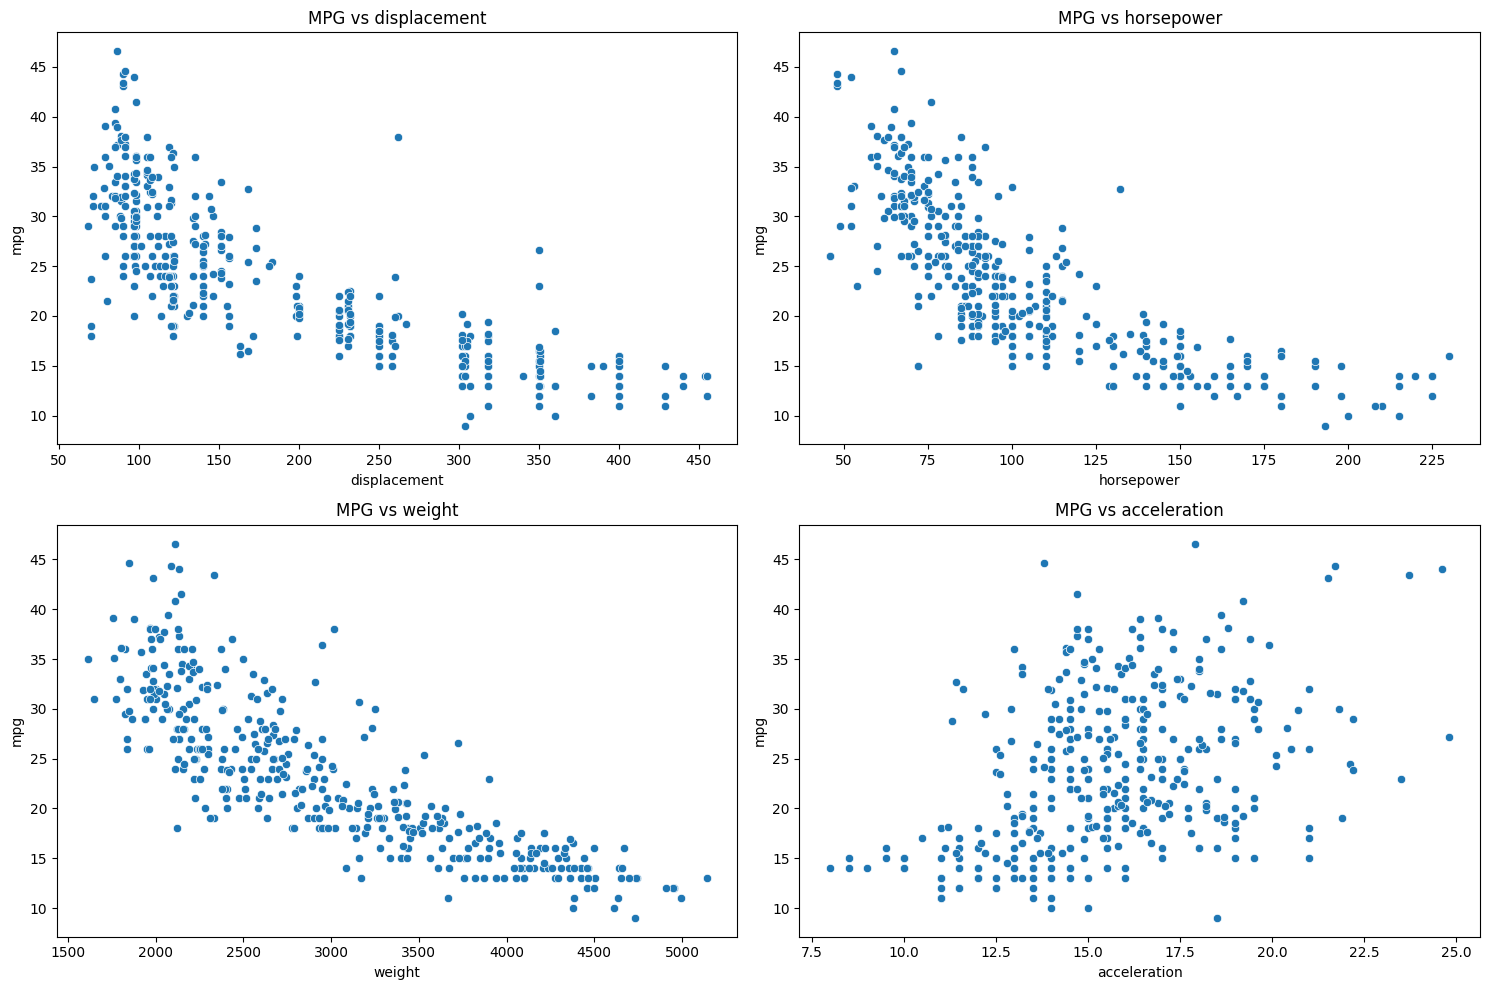

In [11]:
import statsmodels.api as sm

continuous_vars = ['displacement', 'horsepower', 'weight', 'acceleration']

plt.figure(figsize=(15, 10))
for i, var in enumerate(continuous_vars, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=mpg, x=var, y='mpg')
    plt.title(f'MPG vs {var}')
plt.tight_layout()
plt.show()

**Observation:** `displacement`, `horsepower`, and `weight` show a clear curved, inverse relationship with `mpg` (miles per gallon). As these values increase, fuel efficiency drops, but the drop flattens out. `acceleration` has a weak positive relationship.

**Suggested Transformation:** 

By physics/intuitive logic, fuel consumption (gallons per mile) is often linearly related to work/energy. `mpg` is the inverse of consumption. Therefore, a **reciprocal transformation ($1/X$)** on the regressors is plausible. Alternatively, a **log transformation ($\log(X)$)** is also commonly used to linearize such decaying relationships.

Let's try the **Reciprocal Transformation ($1/X$)** for `displacement`, `horsepower`, and `weight`.

Mathematical Model:
$$ \text{mpg} = \beta_0 + \beta_1 \left( \frac{1}{\text{explanatory\_variable}} \right) + \epsilon $$

### (b) Fit Simple Regression with Transformed Regressor

In [12]:
# Create transformed variables
mpg['inv_displacement'] = 1 / mpg['displacement']
mpg['inv_horsepower'] = 1 / mpg['horsepower']
mpg['inv_weight'] = 1 / mpg['weight']

target = 'mpg'
predictors = ['inv_displacement', 'inv_horsepower', 'inv_weight']
original_predictors = ['displacement', 'horsepower', 'weight']

models = {}
results = {}

for pred, orig in zip(predictors, original_predictors):
    X = sm.add_constant(mpg[pred])
    y = mpg[target]
    model = sm.OLS(y, X).fit()
    models[pred] = model
    results[pred] = model.summary()
    
    print(f"\n--- Regression Results for MPG vs 1/{orig} ---")
    print(model.summary())


--- Regression Results for MPG vs 1/displacement ---
                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     759.7
Date:                Sun, 08 Feb 2026   Prob (F-statistic):           1.38e-93
Time:                        20:39:42   Log-Likelihood:                -1149.3
No. Observations:                 392   AIC:                             2303.
Df Residuals:                     390   BIC:                             2311.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

### (c) Interpret the Output

In [13]:
# Just printing out key stats for interpretation helper
for pred in predictors:
    print(f"{pred}: R-squared = {models[pred].rsquared:.3f}, P-value = {models[pred].pvalues.iloc[1]:.3e}")

inv_displacement: R-squared = 0.661, P-value = 1.376e-93
inv_horsepower: R-squared = 0.667, P-value = 3.487e-95
inv_weight: R-squared = 0.707, P-value = 6.220e-106


All three transformed models show strong statistical significance ($p < 0.05$). The $R^2$ values indicate how much variance in `mpg` is explained by the inverse of the predictor. For example, if `inv_weight` has a high $R^2$, it means the reciprocal of weight is a very good predictor of fuel efficiency.

The coefficient $\beta_1$ for $1/X$ is positive in these cases (since standard `mpg` vs `weight` is negative, `mpg` vs `1/weight` should be positive). This makes sense: as $1/weight$ increases (weight decreases), `mpg` increases.

### (e) Diagnostics for the 'Best' Transformed Model

Let's pick the model with the highest $R^2$ (likely `inv_displacement` or `inv_weight` based on typical physics) and diagnostics.

Best model is based on: inv_weight (R^2 = 0.707)


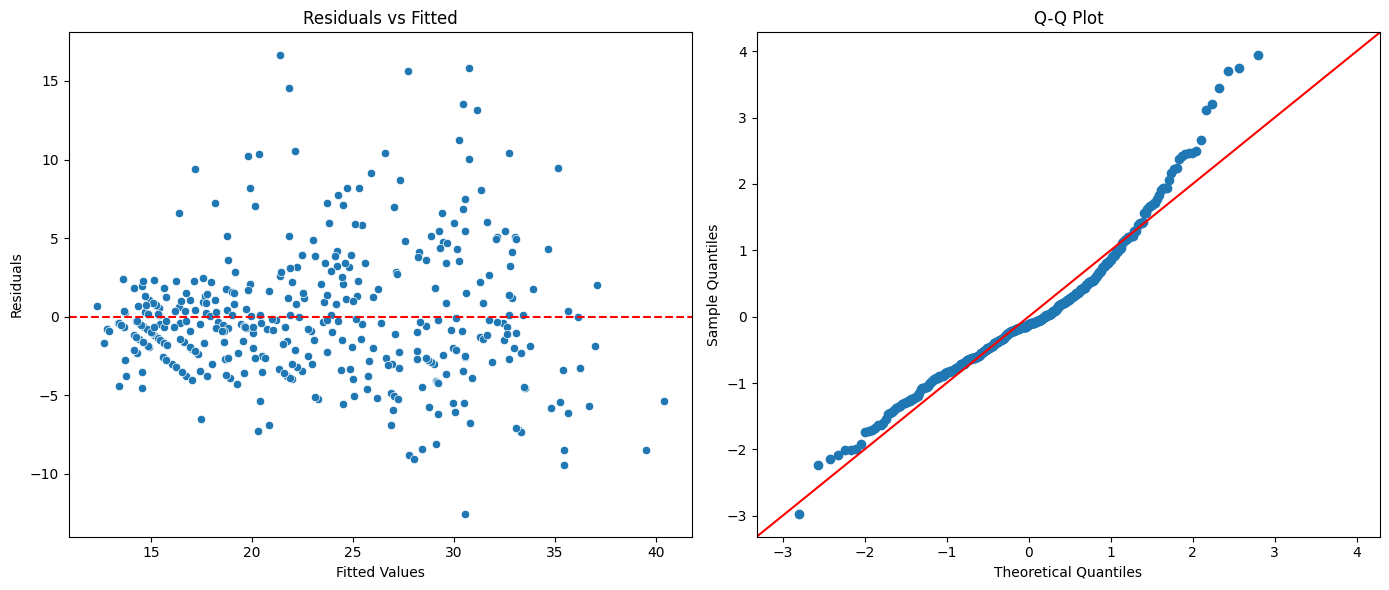

In [14]:
# Select the best model
best_pred = max(models, key=lambda k: models[k].rsquared)
best_model_fit = models[best_pred]
print(f"Best model is based on: {best_pred} (R^2 = {best_model_fit.rsquared:.3f})")

# Diagnostics
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Residuals vs Fitted
fitted_vals = best_model_fit.fittedvalues
residuals = best_model_fit.resid

sns.scatterplot(x=fitted_vals, y=residuals, ax=ax[0])
ax[0].axhline(0, color='red', linestyle='--')
ax[0].set_xlabel('Fitted Values')
ax[0].set_ylabel('Residuals')
ax[0].set_title('Residuals vs Fitted')

# QQ Plot
sm.qqplot(residuals, line='45', fit=True, ax=ax[1])
ax[1].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

**Comparison to Original Linear Case:**

*   **Residuals vs Fitted:** In the original non-transformed model, we would likely see a "U-shape" in the residuals, indicating that a linear line failed to capture the curvature. In this transformed model, if the transformation worked well, the residuals should be more randomly scattered around zero without a distinct pattern.
*   **QQ Plot:** Checks for normality of residuals. If the points hug the 45-degree line, the assumption of normally distributed errors holds. Deviations (especially at the tails) usually indicate heavy tails or outliers.